<a href="https://colab.research.google.com/github/arjygh/stocksandoptions/blob/AG-edit-after-DM's-df-tickers/stonks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Call Buy Indicator Code

In [116]:
%%capture capt

##### Importing all packages #####################################
# optional installations: 
#!pip install yfinance --upgrade --no-cache-dir
#!pip3 install pandas_datareader
#!pip3 install matplotlib
#!pip install trading-calendars

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# ___library_import_statements___
import pandas as pd

import timeit
import traceback

# for pandas_datareader, otherwise it might have issues, sometimes there is some version mismatch
pd.core.common.is_list_like = pd.api.types.is_list_like

# make pandas to print dataframes nicely
pd.set_option('expand_frame_repr', False)  

# import pandas_datareader.data as web
# from pandas_datareader import data as pdr
import numpy as np
import matplotlib.pyplot as plt
import datetime as datetime
from datetime import timedelta
import time
import ssl
from urllib import request
import trading_calendars as tc
import pytz

#newest yahoo API 
import yfinance as yahoo_finance

#optional 
# yahoo_finance.pdr_override()
%matplotlib inline

## Defining Functions

In this section functions for several technical indicators are coded:
1. RSI 
2. Stochastic Slow
3. MACD

In [391]:
def computeRSI(dataframe, time_window):
    
    '''RSI = Relative Strength Index (https://www.investopedia.com/terms/r/rsi.asp)'''
    
    diff = dataframe.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)

    return rsi


def stochastics(dataframe, low, high, close, k, d):
    """
    Fast stochastic calculation
    %K = (Current Close - Lowest Low)/
    (Highest High - Lowest Low) * 100
    %D = 3-day SMA of %K

    Slow stochastic calculation
    %K = %D of fast stochastic
    %D = 3-day SMA of %K

    When %K crosses above %D, buy signal 
    When the %K crosses below %D, sell signal
    
    https://www.investopedia.com/terms/s/stochasticoscillator.asp
    """

    df = dataframe.copy()

    # Set minimum low and maximum high of the k stoch
    low_min  = df[low].rolling(window = k).min()
    high_max = df[high].rolling(window = k).max()

    # Fast Stochastic
    df['k_fast'] = 100 * (df[close] - low_min)/(high_max - low_min)
    df['d_fast'] = df['k_fast'].rolling(window = d).mean()

    # Slow Stochastic
    df['k_slow'] = df["d_fast"]
    df['d_slow'] = df['k_slow'].rolling(window = d).mean()
    df['d_div'] = df['d_fast'] - df['d_slow']

    return df

def MACD(dataframe,close,span1,span2,sig_span):
    
    """
    EMA = exponential moving average
    MACD = Moving Average Convergence Divergence = 12Period EMA - 26Period EMA
    Signal  = 9Period EMA of MACD
    
    https://www.investopedia.com/terms/m/macd.asp
    
    """
    
    df = dataframe.copy()
    exp1 = df[close].ewm(span=span1, adjust=False).mean()
    exp2 = df[close].ewm(span=span2, adjust=False).mean()
    macd = exp1-exp2
    exp3 = macd.ewm(span=sig_span, adjust=False).mean()
    df['MACD line'] = macd
    df['Sig Line'] = exp3
    df['MACD_Div'] = macd-exp3
    return df

def calc_slope(x):
    slope = np.polyfit(range(len(x)), x, 1)[0]
    return slope

def calc_intercept(x):
    intercept = np.polyfit(range(len(x)), x, 1)[1]
    return intercept

def CBI_func(ticker, ticker_df, test_days, holding_days, vol_cutoff, vol_avg_window, 
             RSI_trend_days, RSI_low, RSI_hi, MACD_Div_trend_days, d_slow_trend_days, d_slow_low, d_slow_hi):
    """
    ticker - S&P500 ticker for which stock prices are obtained
    start_time - earliest date at which the stock_price is obtained from yfinance
    end_time - latest date at which the stock price is obtained from yfinance
    trade_date - a date between the start_time and end_time at which a hypothetical trade is entered

    All Technical Indicators are calculated with the "PAST" data and Price changes are calculated with the "FUTURE" data as defined below:
    start_time........................trade_date..........................end_time
    [..............PAST..............]          [...........FUTURE...............]

    CBI [Cumulative Buying Index]:
    - Average of scores calculated from value on trade date, slope and intercept of 'x' days before the trade date of the following Indicators: 
      - Stochastic slow - 14 day average
      - MACD Divergence - standard 12,26,9 day
    - Values closer to zero are strong indicators and the distance from zero defines the strength of the indicator, however, within small intervals 
      distance from zero may not necessarily correlate with strength. For eg: 
        - CBI of 0.1 and 0.5 is highly likely to indicate strong and weak buy respectively
        - CBI of 0.1 and 0.15 may not indicate that the former is a stronger buy than the latter

    """
    df0 = ticker_df
    df0['Symbol'] = ticker
    
    # Call functions to calculate the Technical Indicators for each date (row) in the dataframe,...
    # append as columns to the same dataframe
    df0['RSI'] = computeRSI(df0['Adj Close'].copy(), 14)
    df0 = stochastics( df0, 'Low', 'High', 'Close', 14, 3 )
    df0 = MACD(df0, 'Close', 12, 26, 9)
    

    ## SM: change to calculate slope by polyfit, not 2-pt difference ##
    # set min_periods=2 to allow subsets less than trend days.
    df0['RSI_slope'] = df0['RSI'].rolling(window=RSI_trend_days, min_periods=2).apply(calc_slope)
    df0['d_slow_slope'] = df0['d_slow'].rolling(window=d_slow_trend_days, min_periods=2).apply(calc_slope)
    df0['MACD_Div_slope'] = df0['MACD_Div'].rolling(window=MACD_Div_trend_days, min_periods=2).apply(calc_slope)
    df0['MACD_Div_intercept'] = df0['MACD_Div'].rolling(window=MACD_Div_trend_days, min_periods=2).apply(calc_intercept)
    
    #print(df0)
    df0['avg_volume'] = df0.iloc[:,6].rolling(window=vol_avg_window).mean()

    passed_trades = pd.DataFrame()
    
    # intializing dataframe
    column_names = ['Symbol', 'Trade_Date','CBI_SS','CBI_MACD','CBI','Trade_Price','Price_Delta', 
                    'Avg_Volume', 'RSI_val', 'RSI_slope', 'SS_val', 'SS_slope', 
                    'MSCD_Div_val', 'MACD_Div_slope', 'MACD_Div_intercept']
    

    df0['Price_Delta'] = (df0['Close'].rolling(holding_days).max().shift(-holding_days+1) - df0['Close'])/df0['Close']*100.
    df0['Price_Delta'] = np.where(df0['Price_Delta']<=0., 
                                        (df0['Close'].rolling(holding_days).min().shift(-holding_days+1) 
                                         - df0['Close'])/df0['Close']*100., df0['Price_Delta'])
    
#    # Get NYSE Calendar
#    xnys = tc.get_calendar("XNYS")
    
    df0['Vol and RSI criteria'] = np.where((df0['avg_volume'] >= vol_cutoff) & (df0['RSI'] > RSI_low) 
        & (df0['RSI'] < RSI_hi) & (df0['RSI_slope'] > 0), True, False)

    df0['CBI_SS'] = np.where((df0['Vol and RSI criteria'] == True) & (df0['d_slow'] > d_slow_low) 
        & (df0['d_slow'] < d_slow_hi) & (df0['d_slow_slope'] > 0), 
                             (abs(df0['d_slow'] - 0.5*(d_slow_hi + d_slow_low))/(0.5*(d_slow_hi - d_slow_low))), 10.)
    
    
    df0['CBI_MACD'] = np.where((df0['Vol and RSI criteria'] == True) & (df0['MACD_Div'] < 0.) & (df0['MACD_Div_intercept'] < 0.)
        & (df0['MACD_Div_slope'] > 0.), (df0['MACD_Div']/df0['MACD_Div_intercept']), 10.)
    
    df0['CBI'] = 0.5*(df0['CBI_SS'] + df0['CBI_MACD'])
    
            
    return df0
  

## Main Code - Testing for 1 Ticker

In [392]:
def connect_and_get_cbi_for_dataframe(ticker, dataframe, test_days, holding_days):
    """
    Call CBI function to get relevant data
    """
    # Get Stock Prices for the ticker between start_time and end_time

    try:
        dataframe.reset_index(inplace=True)

        output = CBI_func(ticker, dataframe, test_days, holding_days, vol_cutoff = 2.0e6, 
                          vol_avg_window = 7, RSI_trend_days = 7, RSI_low = 40., RSI_hi = 75., MACD_Div_trend_days = 4, 
                          d_slow_trend_days = 4, d_slow_low = 10., d_slow_hi = 50.)
        return output
    except Exception as e:
        print('Analyzed Security: ', ticker_list, 'No Data')
        traceback.print_exc()
        return pd.DataFrame()

def connect_and_get_cbi_for_ticker_list(ticker_list, start_time_for_fin_data, end_time_for_fin_data, test_days, holding_days):
    """
    Connect with Yahoo Finance API first to fetch the data within the test_days period
    Returns a filled data frame if available, else an empty dataframe
    """
    # Get Stock Prices for the ticker between start_time and end_time
    tickers_ssv = ' '.join(ticker_list)
    print("Fetching tickers for ", tickers_ssv)
    start = timeit.default_timer()
    ticker_df = yahoo_finance.download(tickers_ssv, start=start_time, end=end_time, group_by="ticker", threads=True)
    print("Fetching tickers took seconds: ", timeit.default_timer() - start)

    no_data_tickers = []
    full_df = pd.DataFrame()

    # If it is a single ticker call, no need to extract the ticker from dataframe
    if len(ticker_list) <= 1:
        output = connect_and_get_cbi_for_dataframe(ticker_list[0], ticker_df, test_days, holding_days)
        if output.empty:
            no_data_tickers.append(ticker_list[0])
        return output, no_data_tickers

    for ticker in ticker_list:
        output = connect_and_get_cbi_for_dataframe(ticker,  ticker_df[ticker], test_days, holding_days)
        if output.empty:
            no_data_tickers.append(ticker)
        else:       
            full_df = full_df.append(output, ignore_index = True)
    return full_df, no_data_tickers


TEST CODE: In this section, a single ticker is analyzed for a range of dates

In [393]:
#%%capture capt

no_data_tickers = []
ticker_list = ["MMM"]

# start_time and end_time to fetch data from yahoo
start_time = '2019-11-14'
end_time = '2021-04-01'

# start and end dates of trading period
_trade_days_start = '2020-01-01'
_trade_days_end = '2020-06-20'

test_days = pd.bdate_range(_trade_days_start, _trade_days_end)
holding_days = 15

output, no_data_tickers = connect_and_get_cbi_for_ticker_list(ticker_list, start_time, end_time, 
                                                              test_days, holding_days)     
output.head()

Fetching tickers for  MMM
[*********************100%***********************]  1 of 1 completed
Fetching tickers took seconds:  0.3172999139933381


,Date,Open,High,Low,Close,Adj Close,Volume,Symbol,RSI,k_fast,...,RSI_slope,d_slow_slope,MACD_Div_slope,MACD_Div_intercept,avg_volume,Price_Delta,Vol and RSI criteria,CBI_SS,CBI_MACD,CBI
0,2019-11-14,169.979996,172.320007,169.929993,170.929993,162.044067,1613900,MMM,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.555790,False,10.0,10.0,10.0
1,2019-11-15,171.660004,172.690002,171.039993,171.880005,162.944687,2616900,MMM,NaN,NaN,...,NaN,NaN,0.060628,8.728784e-19,NaN,-4.369333,False,10.0,10.0,10.0
2,2019-11-18,170.789993,171.199997,169.169998,170.539993,161.674347,2364600,MMM,NaN,NaN,...,NaN,NaN,0.004897,1.857669e-02,NaN,0.545331,False,10.0,10.0,10.0
3,2019-11-19,171.720001,171.720001,169.529999,170.679993,161.807053,1791800,MMM,NaN,NaN,...,NaN,NaN,-0.009225,2.799162e-02,NaN,0.462859,False,10.0,10.0,10.0
4,2019-11-20,169.789993,170.000000,167.149994,167.770004,159.048355,2689500,MMM,NaN,NaN,...,NaN,NaN,-0.084662,8.771908e-02,NaN,2.205398,False,10.0,10.0,10.0


## MAIN CODE - Full SP500

In [715]:
%%capture capt

url="https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
##START - only needed when  getting SSLVerificationError in local##
context = ssl._create_unverified_context()
response = request.urlopen(url, context=context)
html = response.read()
##END - only needed when  getting SSLVerificationError in local##
table=pd.read_html(html)
sp500 = table[0]
sp500 = sp500[['Symbol','Security','GICS Sector']]
sector_list = list(sp500['GICS Sector'].unique())
print(sector_list)
sp500.head(5)

In [716]:
%%capture capt

# dropping tickers with . like BRK.B
sp500 = sp500[sp500['Symbol'] != "."]

no_data_tickers = []

#initialize df
full_df0 = pd.DataFrame()
passed_trades = pd.DataFrame()

# start_time and end_time to fetch data from yahoo
start_time = '2014-09-01'
end_time = '2021-03-31'

# start and end dates of trading period
trade_days_start = '2015-01-01'
trade_days_end = '2020-12-31'
test_days = pd.bdate_range(trade_days_start, trade_days_end)

sector_list = list(sp500['GICS Sector'].unique())
total = sp500['Symbol'].nunique()

#sector_list = ['Financials']
#ticker_list = ['APA']

for sector in sector_list:
    ticker_list = list(sp500[sp500['GICS Sector']==sector]['Symbol'])
    full_df, no_data_tickers_list =  connect_and_get_cbi_for_ticker_list(ticker_list, start_time, 
                                                                                  end_time, test_days, 
                                                                                  holding_days = 0)
    print("Passed df for ", ticker_list)
    print(full_df)
    print("Done passed df")
    full_df0 = full_df0.append(full_df)
    no_data_tickers.append(no_data_tickers_list)

if not full_df0.size:
    raise Exception("No passed trades  found")
    


In [800]:
#greater than the start date and smaller than the end date - 60 trade days ~3 months before 12/31/2020
holding_days = 30
full_df0['Price_Delta_maximus'] = ((full_df0['Close'].rolling(holding_days).max().shift(-holding_days+1) 
                                    - full_df0['Close'])/full_df0['Close']*100.)
full_df0['Price_Delta_maximus'] = np.where(full_df0['Price_Delta_maximus']<=0., 
                                           (full_df0['Close'].rolling(holding_days).min().shift(-holding_days+1)
                                            - full_df0['Close'])/full_df0['Close']*100., full_df0['Price_Delta_maximus'])

mask = (full_df0['Date'] >= test_days[0]) & (full_df0['Date'] <= test_days[-60]) & (full_df0['CBI']<1.0)
passed_trades_cbi = full_df0.loc[mask].copy()

passed_trades_cbi = passed_trades_cbi.merge(sp500, how='left', on='Symbol')
passed_trades_cbi.head()

#run_time = datetime.datetime.now().date().isoformat()
filename = 'fulldf_sp500_from_'+str(trade_days_start)+'_to_'+str(trade_days_end)+'.csv'
full_df0.to_csv(filename)

filename = 'passed_cbi_sp500_from_'+str(trade_days_start)+'_to_'+str(trade_days_end)+'.csv'
passed_trades_cbi.to_csv(filename)

# CBI_cutoff = 1.0
# passed_trades = passed_trades_cbi[passed_trades_cbi['CBI']<CBI_cutoff].reset_index(drop=True)

#sp500.to_csv('sp500.csv')

In [803]:
#%%capture capt
#passed_trades.sort_values(by=['Date', 'CBI'], ascending=False, inplace=True)
CBI_cutoff = 1.0
passed_trades = passed_trades_cbi[passed_trades_cbi['CBI']<CBI_cutoff].reset_index(drop=True)
passed_trades['RSI_Slope_sell'] = np.nan
passed_trades['MACD_Div_slope_sell'] = np.nan
passed_trades['MACD_Div_intercept_sell'] = np.nan
passed_trades['d_slow_sell'] = np.nan
passed_trades['d_div_sell'] = np.nan
passed_trades['RSI_sell'] = np.nan
passed_trades["Buy_Price"] = np.nan
passed_trades["Buy_Date"] = np.nan
passed_trades["Sell_Price"] = np.nan
passed_trades["Sell_Date"] = np.nan
passed_trades["Holding_Period"] = np.nan
passed_trades["Price_Delta"] = np.nan
passed_trades['Buy_Slippage'] = np.nan
passed_trades['Sell_Slippage'] = np.nan
passed_trades['Price_Delta_realized'] = np.nan
passed_trades['Total_Slippage'] = np.nan
passed_trades['Profit or Loss'] = np.nan
passed_trades['Type of Sale'] = ''


#passed_trades.head()
#full_df0.head()
for buy in passed_trades.index:
    ticker = passed_trades.loc[buy]['Symbol']
    CBI_price = passed_trades.loc[buy]['Close']
    buy_chance = passed_trades.loc[buy]['Date'] + timedelta(days=1)
    # trade date may not be +1 day after signal date due to holidays
    buy_date = full_df0.loc[(full_df0['Date'] >= buy_chance) & (full_df0['Symbol'] == ticker)]['Date'].iloc[0]
    buy_price = full_df0.loc[(full_df0['Date'] >= buy_date) & (full_df0['Symbol'] == ticker)]['Open'].iloc[0]
    buy_slippage = 100.*(buy_price - CBI_price)/CBI_price
    
    passed_trades.at[buy, "Buy_Price"] = buy_price
    passed_trades.at[buy, "Buy_Date"] = buy_date
    passed_trades.at[buy, "Buy_Slippage"] = buy_slippage
    
    
    
    # enter conditions for sale
    all_sell_chances = full_df0.loc[(full_df0['Symbol'] == ticker) & (full_df0['Date'] > buy_date) 
                                    & (full_df0['Date'] <= test_days[-1])].copy()
    all_sell_chances['Price_Delta'] = 100.*(all_sell_chances['Close'] - buy_price)/buy_price
    
    # stop loss cutoff date
    stop_loss_cutoff = -15.
    stop_loss_date = all_sell_chances[all_sell_chances['Price_Delta']<=stop_loss_cutoff]['Date'].min()
    
    
    # signal selloff date
    signal_sell_date = all_sell_chances[(all_sell_chances['RSI_slope']<=0.0) 
                                         & (all_sell_chances['MACD_Div_slope']<=0.0) 
                                         & (all_sell_chances['MACD_Div_intercept']>=0) 
                                         & (all_sell_chances['d_slow']>=50.) 
                                         & (all_sell_chances['Price_Delta']>=0)]['Date'].min()
    
    # force sell date - 2nd last trading day
    force_sell_date = all_sell_chances['Date'].iloc[-2]
    
    # realized sell date
    realized_sell_date = pd.to_datetime([stop_loss_date, signal_sell_date, force_sell_date]).min()
    
    #without stop loss
    #signal_sell_chance = all_sell_chances[(all_sell_chances['Date']==signal_sell_date)]
    
    #with stop loss
    if stop_loss_date==realized_sell_date:
        
        signal_sell_chance = all_sell_chances[(all_sell_chances['Date']==stop_loss_date)]
        passed_trades.at[buy, 'Type of Sale'] = 'Stop Loss'
        signal_sell_price = signal_sell_chance['Close']
        first_sell_chance = all_sell_chances[all_sell_chances['Date']>stop_loss_date].iloc[0]
        
    elif signal_sell_date==realized_sell_date:
        
        signal_sell_chance = all_sell_chances[(all_sell_chances['Date']==signal_sell_date)]
        passed_trades.at[buy, 'Type of Sale'] = 'Signal'
        signal_sell_price = signal_sell_chance['Close']
        first_sell_chance = all_sell_chances[all_sell_chances['Date']>signal_sell_date].iloc[0]
        
    else:   
        print(ticker, buy_date, realized_sell_date)
        passed_trades.at[buy, 'Type of Sale'] = 'Force'
        signal_sell_price = np.nan
        first_sell_chance = all_sell_chances.iloc[-1]
        
        
    sell_price = first_sell_chance['Open']
    sell_date = first_sell_chance['Date']
    sell_slippage = 100.*(sell_price - signal_sell_price)/signal_sell_price
    price_delta_realized = 100.*(sell_price - buy_price)/buy_price
    holding_delta = (sell_date - buy_date)
    passed_trades.at[buy, 'Sell_Price'] = sell_price
    passed_trades.at[buy, 'Sell_Date'] = first_sell_chance['Date']#.strftime("%Y-%m-%d")
    passed_trades.at[buy, 'Price_Delta_realized'] = price_delta_realized
    passed_trades.at[buy, 'Holding_Period'] = holding_delta.days 
    passed_trades.at[buy, 'Sell_Slippage'] = sell_slippage
    passed_trades.at[buy, 'Total_Slippage'] = sell_slippage - buy_slippage
    
    # sell inidicators
    if (passed_trades.at[buy, 'Type of Sale'] == 'Stop Loss') or (passed_trades.at[buy, 'Type of Sale'] == 'Signal'):
        passed_trades.at[buy, 'Price_Delta'] = signal_sell_chance['Price_Delta']
        passed_trades.at[buy, 'RSI_sell'] = signal_sell_chance['RSI']
        passed_trades.at[buy, 'RSI_Slope_sell'] = signal_sell_chance['RSI_slope']
        passed_trades.at[buy, 'MACD_Div_slope_sell'] = signal_sell_chance['MACD_Div_slope']
        passed_trades.at[buy, 'MACD_Div_intercept_sell'] = signal_sell_chance['MACD_Div_intercept']
        passed_trades.at[buy, 'd_slow_sell'] = signal_sell_chance['d_slow']
        passed_trades.at[buy, 'd_div_sell'] = signal_sell_chance['d_div']


passed_trades['Profit or Loss'] = np.where(passed_trades['Price_Delta_realized']>=0., 'Profit', 'Loss')
passed_trades.head()
print('###### DONE! ######')

AMGN 2020-09-17 00:00:00 2020-12-30 00:00:00
AMGN 2020-09-18 00:00:00 2020-12-30 00:00:00
AMGN 2020-09-21 00:00:00 2020-12-30 00:00:00
AMGN 2020-09-30 00:00:00 2020-12-30 00:00:00
BAX 2020-08-14 00:00:00 2020-12-30 00:00:00
BAX 2020-08-18 00:00:00 2020-12-30 00:00:00
BAX 2020-09-15 00:00:00 2020-12-30 00:00:00
BAX 2020-10-01 00:00:00 2020-12-30 00:00:00
GILD 2020-10-01 00:00:00 2020-12-30 00:00:00
MRK 2020-09-17 00:00:00 2020-12-30 00:00:00
MRK 2020-09-18 00:00:00 2020-12-30 00:00:00
MRK 2020-09-21 00:00:00 2020-12-30 00:00:00
JNPR 2020-09-17 00:00:00 2020-12-30 00:00:00
JNPR 2020-09-21 00:00:00 2020-12-30 00:00:00
JNPR 2020-09-22 00:00:00 2020-12-30 00:00:00
NLOK 2020-09-28 00:00:00 2020-12-30 00:00:00
WU 2020-09-18 00:00:00 2020-12-30 00:00:00
BWA 2020-10-05 00:00:00 2020-12-30 00:00:00
KMX 2020-10-06 00:00:00 2020-12-30 00:00:00
NEM 2020-08-21 00:00:00 2020-12-30 00:00:00
NEM 2020-08-24 00:00:00 2020-12-30 00:00:00
AMT 2020-09-30 00:00:00 2020-12-30 00:00:00
AMT 2020-10-01 00:00:00 

## Plots

3795 / 22998


,Date,Open,High,Low,Close,Adj Close,Volume,Symbol,RSI,k_fast,...,Buy_Date,Sell_Price,Sell_Date,Holding_Period,Buy_Slippage,Sell_Slippage,Price_Delta_realized,Total_Slippage,Profit or Loss,Type of Sale
6,2015-03-20,166.089996,167.130005,165.389999,166.490005,138.944992,4371800.0,MMM,52.301896,60.831239,...,2015-03-23 00:00:00,141.860001,2015-08-25 00:00:00,155.0,0.204214,2.366863,-14.967333,2.162649,Loss,Stop Loss
30,2018-04-05,218.639999,220.309998,216.559998,218.669998,196.767960,2879900.0,MMM,41.407187,32.055742,...,2018-04-06 00:00:00,186.570007,2018-10-25 00:00:00,202.0,-0.580786,1.100040,-14.181227,1.680826,Loss,Stop Loss
51,2020-02-12,164.240005,165.039993,163.570007,163.800003,155.484940,2736400.0,MMM,42.235855,30.648496,...,2020-02-13 00:00:00,141.009995,2020-03-13 00:00:00,29.0,-1.245426,5.562204,-12.827646,6.807631,Loss,Stop Loss
52,2020-02-14,159.850006,161.139999,158.820007,161.009995,154.220581,2233500.0,MMM,41.181249,29.009976,...,2020-02-18 00:00:00,141.009995,2020-03-13 00:00:00,24.0,-0.403698,5.562204,-12.066604,5.965902,Loss,Stop Loss
53,2020-03-04,147.020004,154.000000,145.990005,153.979996,147.487030,5773800.0,MMM,45.419462,54.733203,...,2020-03-05 00:00:00,128.160004,2020-03-23 00:00:00,18.0,-2.065199,2.618308,-15.013262,4.683506,Loss,Stop Loss


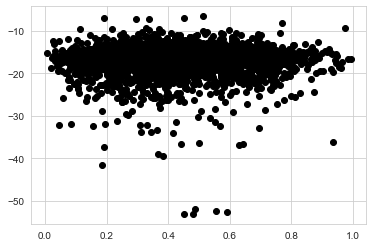

In [804]:
#passed_trades = pd.read_csv(filename)
string = 'Stop Loss'
x = passed_trades[passed_trades['Type of Sale']==string]['CBI']
y = passed_trades[passed_trades['Type of Sale']==string]['Price_Delta_realized'].values
plt.plot(x,y,'o', color='black')
print(len(passed_trades[passed_trades['Type of Sale']==string].index),"/",len(passed_trades.index))
passed_trades[passed_trades['Type of Sale']==string].head()


<AxesSubplot:xlabel='GICS Sector', ylabel='Sell_Slippage'>

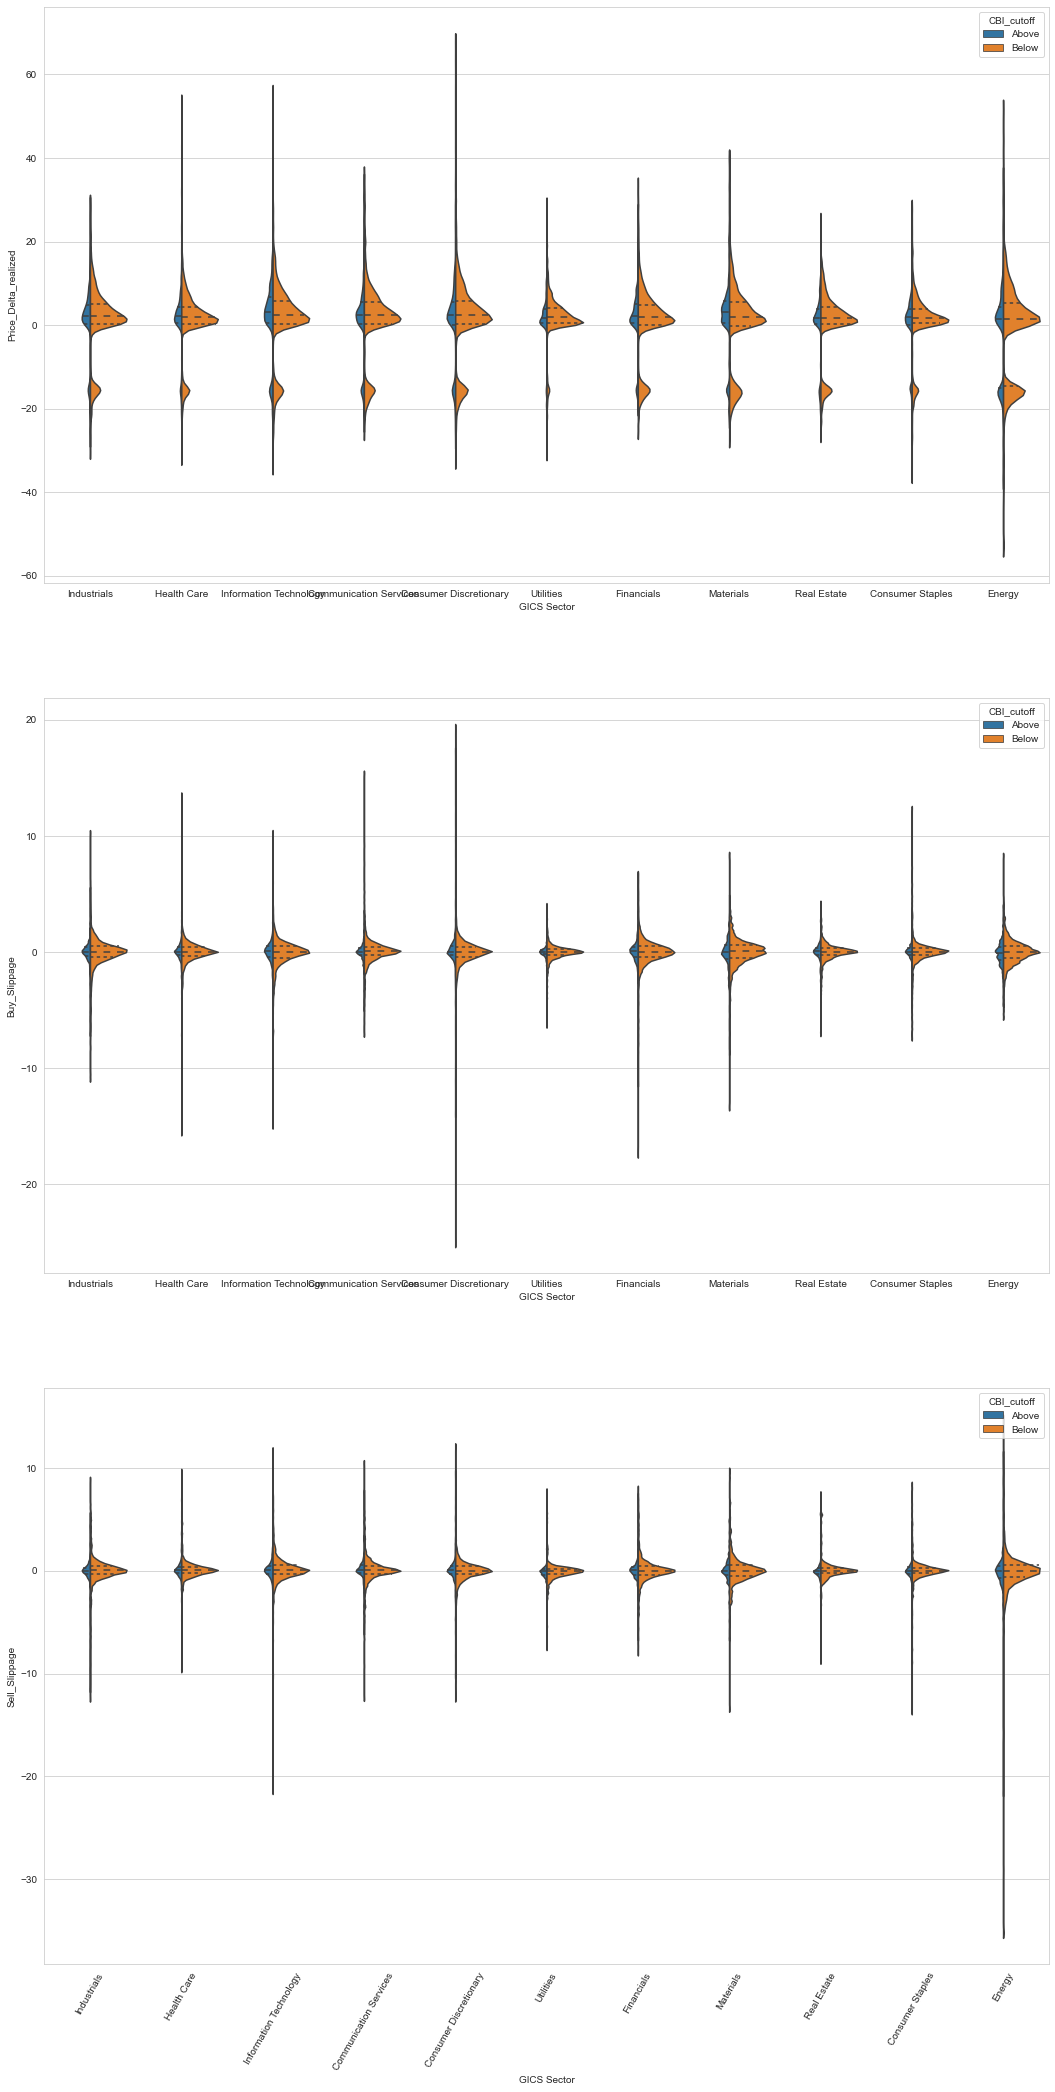

In [805]:
CBI_limit = 0.60
passed_trades['CBI_cutoff'] = np.where(passed_trades['CBI']<CBI_limit, 'Below', 'Above')
import seaborn as sns
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize=(18, 36))
plt.xticks(rotation=60)
sns.violinplot(x="GICS Sector", y="Price_Delta_realized", data=passed_trades, 
                  inner="quartile", split=True, hue='CBI_cutoff', scale='count', bw=0.1, ax=ax[0])
sns.violinplot(x="GICS Sector", y="Buy_Slippage", data=passed_trades, 
                  inner="quartile", split=True, hue='CBI_cutoff', scale='count', bw=0.1, ax=ax[1])
sns.violinplot(x="GICS Sector", y="Sell_Slippage", data=passed_trades, 
                  inner="quartile", split=True, hue='CBI_cutoff', scale='count', bw=0.1, ax=ax[2])

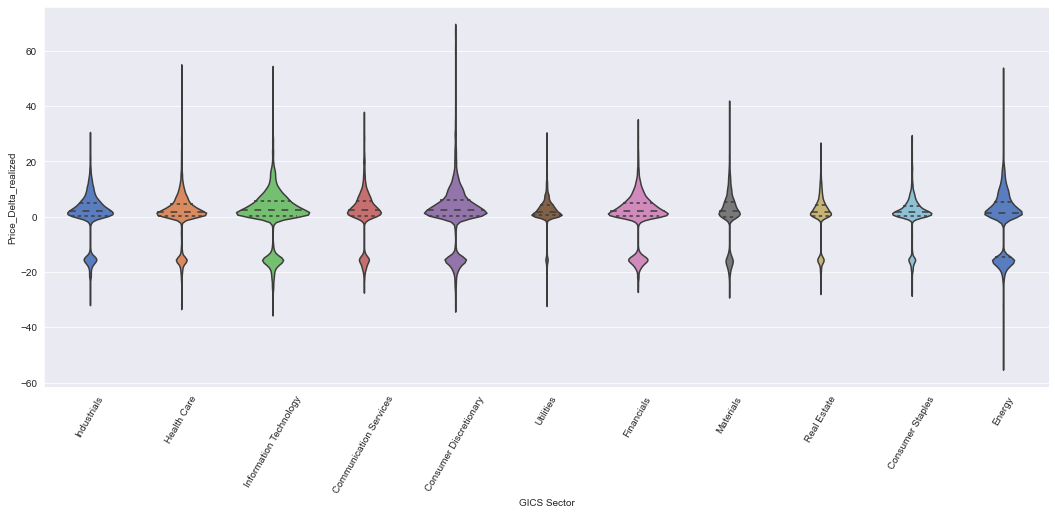

In [806]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(18, 7))
plt.xticks(rotation=60)
ax=sns.violinplot(x="GICS Sector", y="Price_Delta_realized", data=passed_trades[passed_trades['CBI']<=CBI_limit], 
                  inner="quartile", scale='count', bw=0.1, palette='muted')


               Profit or Loss Price_Delta Price_Delta_realized Holding_Period Total_Slippage Price_Delta_maximus
                        count        mean                 mean           mean           mean                mean
Profit or Loss                                                                                                  
Loss                     5034  -12.630134           -12.759054      53.787644      -0.004240           -2.794313
Profit                  17964    4.483563             4.603263      35.062959       0.124648            8.129842
Expected norm return =  0.7375699879607337 % in mean holding period
Expected total return =  169.6263458312095 investement =  22998


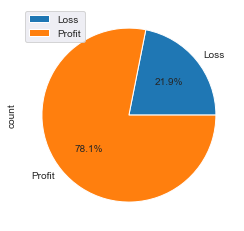

In [807]:
CBI_limit = 1.0
passed_trades_limit = passed_trades[(passed_trades['CBI']<=CBI_limit)]

data = passed_trades_limit.groupby("Profit or Loss").agg({'Profit or Loss': ['count'], 
                                                          'Price_Delta': 'mean', 
                                                          'Price_Delta_realized': 'mean',
                                                          'Holding_Period':'mean', 
                                                          'Total_Slippage':'mean', 
                                                          'Price_Delta_maximus': 'mean'})
data.plot.pie(y='Profit or Loss', autopct="%.1f%%");
print(data)
data.reset_index(inplace=True)
print("Expected norm return = ",(data.iloc[1,1]*data.iloc[1,2]+data.iloc[0,1]*data.iloc[0,2])/(data.iloc[1,1]+data.iloc[0,1]),"% in mean holding period")
print("Expected total return = ",(data.iloc[1,1]*data.iloc[1,2]/100+data.iloc[0,1]*data.iloc[0,2]/100),"investement = ", (data.iloc[1,1]+data.iloc[0,1]))

In [808]:
run_time = datetime.datetime.now().date().isoformat()
filename = 'sp500_passedtrades_stoploss15_from_'+str(trade_days_start)+'_to_'+str(trade_days_end)+'_at_'+str(run_time)+'.csv'
passed_trades.to_csv(filename)

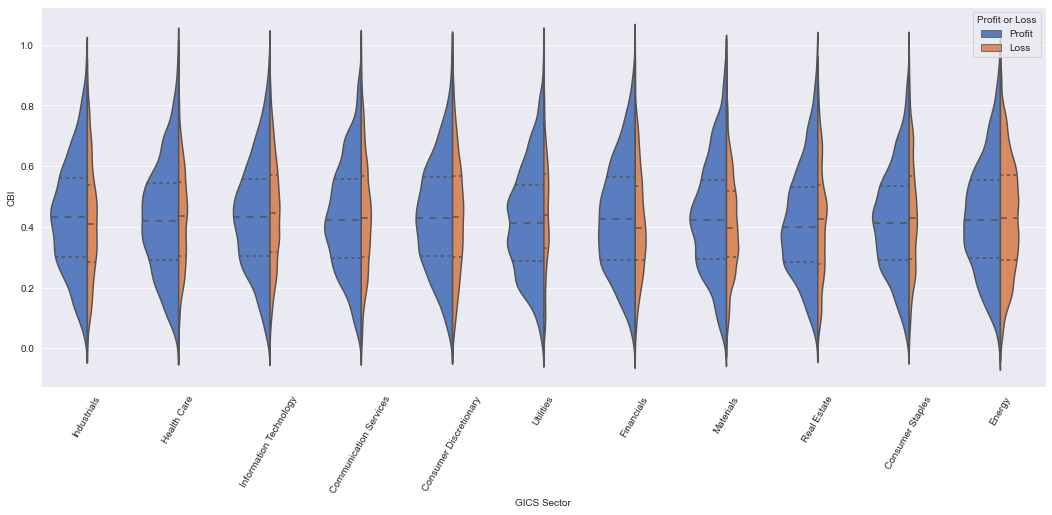

In [809]:

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(18, 7))
plt.xticks(rotation=60)
ax=sns.violinplot(x="GICS Sector", y="CBI", data=passed_trades, hue='Profit or Loss',
                  inner="quartile", scale='count', bw=0.2, palette='muted', split=True)